<a href="https://colab.research.google.com/github/maximdorogov/Practicos_MachineLearning_UNS/blob/main/TP_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:

import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import cv2
from sklearn.model_selection import train_test_split
from sklearn import svm, metrics, preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

In [46]:
def silhouette_analysis(dataset, n_clusters):
  
  import matplotlib.cm as cm

  for n_clusters in range_n_clusters:

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

      # The 1st subplot is the silhouette plot
      # The silhouette coefficient can range from -1, 1 but in this example all
      # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
      # The (n_clusters+1)*10 is for inserting blank space between silhouette
      # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(dataset) + (n_clusters + 1) * 10])

      # Initialize the clusterer with n_clusters value and a random generator
      # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(dataset)

      # The silhouette_score gives the average value for all the samples.
      # This gives a perspective into the density and separation of the formed
      # clusters
    silhouette_avg = metrics.silhouette_score(dataset, cluster_labels)
    print("For n_clusters =", n_clusters,
            "The average silhouette_score is :", silhouette_avg)

      # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(dataset, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
          # Aggregate the silhouette scores for samples belonging to
          # cluster i, and sort them
      ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / n_clusters)
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

          # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

          # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

      ax1.set_title("The silhouette plot for the various clusters.")
      ax1.set_xlabel("The silhouette coefficient values")
      ax1.set_ylabel("Cluster label")

      # The vertical line for average silhouette score of all the values
      ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

      ax1.set_yticks([])  # Clear the yaxis labels / ticks
      ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

      # 2nd Plot showing the actual clusters formed
      colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
      ax2.scatter(dataset[:, 0], dataset[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                  c=colors, edgecolor='k')

      # Labeling the clusters
      centers = clusterer.cluster_centers_
      # Draw white circles at cluster centers
      ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                  c="white", alpha=1, s=200, edgecolor='k')

      for i, c in enumerate(centers):
          ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                      s=50, edgecolor='k')

      ax2.set_title("The visualization of the clustered data.")
      ax2.set_xlabel("Feature space for the 1st feature")
      ax2.set_ylabel("Feature space for the 2nd feature")

      plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % n_clusters),
                  fontsize=14, fontweight='bold')

  plt.show()

In [27]:
def plot_clusters(data, method):

    # Step size of the mesh. Decrease to increase the quality of the VQ.
  h = .01
  x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
  y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  labels = method.predict(np.c_[xx.ravel(), yy.ravel()])
  labels = labels.reshape(xx.shape)

  plt.figure(1)
  plt.figure(figsize=(10, 10))
  plt.clf()
  plt.imshow(labels, interpolation='nearest',
            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
            cmap=plt.cm.Paired,
            aspect='auto', origin='lower')

  plt.plot(data[:, 0], data[:, 1], 'ko', markersize=15)
  # Plot the centroids as a white X
  centroids = kmeans.cluster_centers_
  plt.scatter(centroids[:, 0], centroids[:, 1],
              marker='x', s=169, linewidths=3,
              color='w', zorder=10)

  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.xticks(())
  plt.yticks(())
  plt.show()

Loading the data frame

In [28]:
df_crimes = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectUSA/data/violent_crime.csv")
df_crimes.head()

,Unnamed: 0,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [29]:
# Change "Unnamed: 0" to "States", more significant name.

df_crimes = df_crimes.rename(columns={'Unnamed: 0': 'state'});
df_crimes.head()


,state,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


Normalizing the data frame

In [30]:
# list of categorical data into uncategorical

enc = preprocessing.OrdinalEncoder()
states_numerical = np.array(df_crimes['state']).reshape(-1,1)
enc.fit(states_numerical) 
states_numerical = enc.transform(states_numerical)

# Min max column scaler


min_max_scaler = preprocessing.MinMaxScaler()
df_crimes_scaled = pd.DataFrame(min_max_scaler.fit_transform(df_crimes[['Murder', 'Assault', 'UrbanPop', 'Rape']]))
df_crimes_scaled = df_crimes_scaled.rename(columns={0: 'Murder', 1: 'Assault', 2: 'UrbanPop', 3: 'Rape'})
df_crimes_scaled.head()

,Murder,Assault,UrbanPop,Rape
0,0.746988,0.654110,0.440678,0.359173
1,0.554217,0.746575,0.271186,0.961240
2,0.439759,0.852740,0.813559,0.612403
3,0.481928,0.496575,0.305085,0.315245
4,0.493976,0.791096,1.000000,0.860465


Lets visualize some features

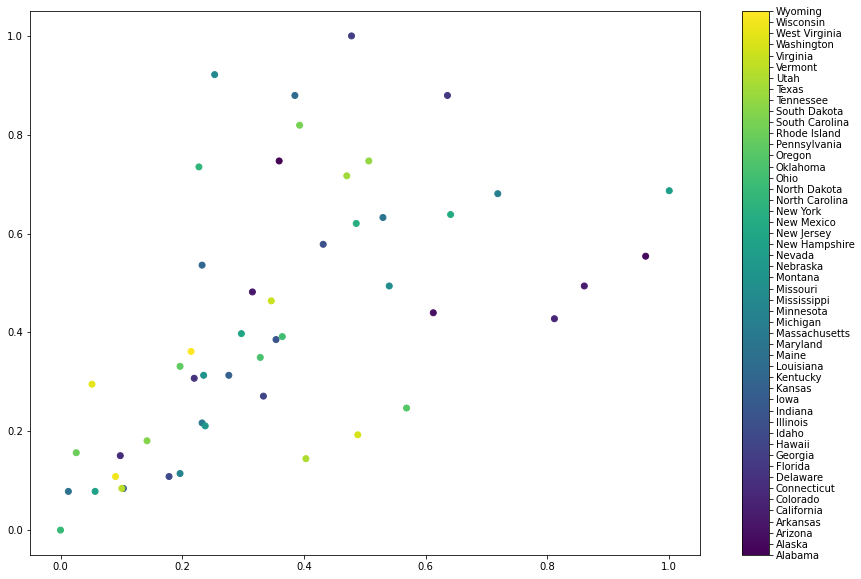

In [31]:
plt.figure(figsize=(15, 10))
all_states = df_crimes['state']
formatter = plt.FuncFormatter(lambda i, *args: all_states[i])
plt.scatter(df_crimes_scaled['Rape'], df_crimes_scaled['Murder'], c=states_numerical )
plt.colorbar(ticks = np.arange(0, len(states_numerical)), format=formatter)

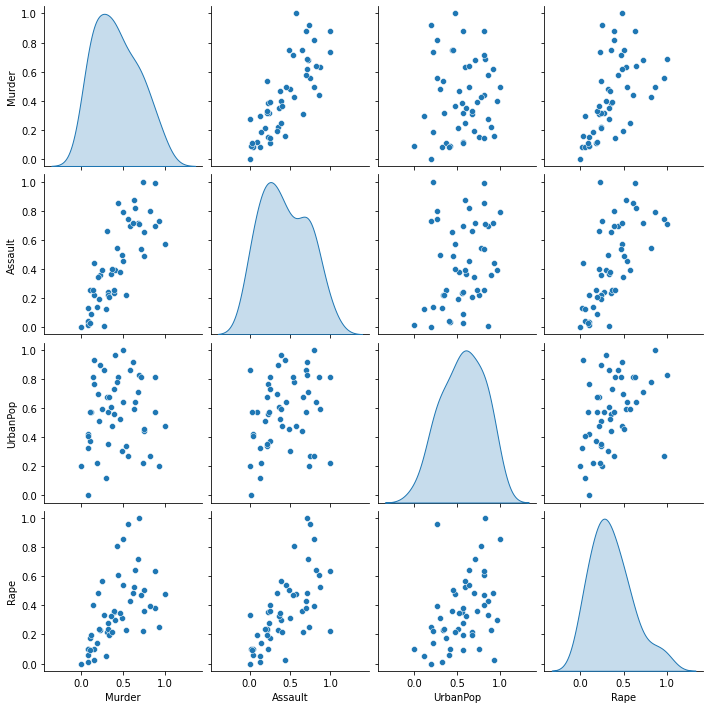

In [32]:
sns.pairplot(df_crimes_scaled, diag_kind="kde")

Lets apply PCA to see a more "clusterizable" data features

In [33]:
n_samples, n_features = df_crimes_scaled.shape

# separate the data
features = df_crimes_scaled.columns

# Separating out the features
data = df_crimes_scaled.loc[:, features].values

pca = PCA(n_components = 2)
principal_components = pca.fit_transform(data)


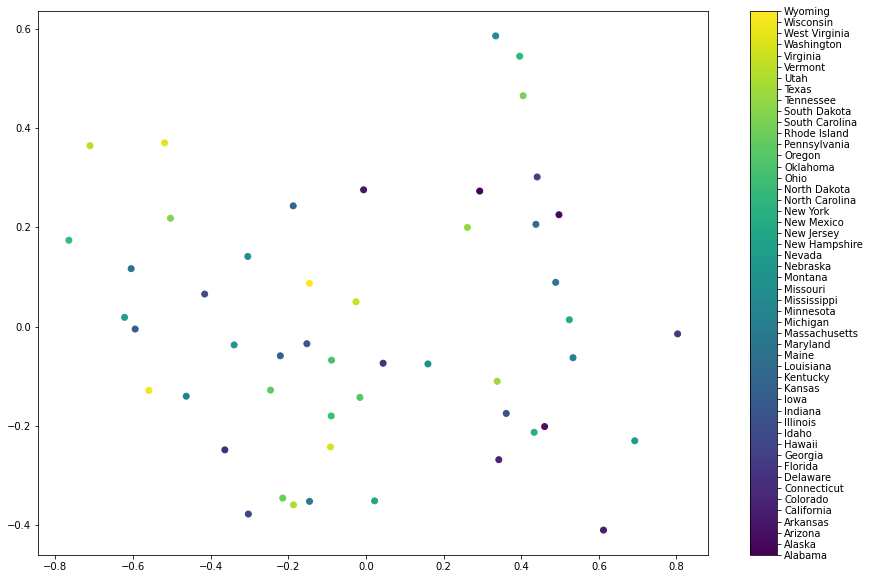

In [34]:
plt.figure(figsize=(15, 10))
plt.scatter(principal_components[:, 0], principal_components[:,1], c=states_numerical )
plt.colorbar(ticks = np.arange(0, len(states_numerical)), format=formatter)

Now lets try K-Means clustering with random number of cluster to check how it works

In [47]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(principal_components)

labels = kmeans.predict(principal_components)

 # The silhouette_score gives the average value for all the samples.
silhouette_avg = metrics.silhouette_score(principal_components, labels)
# Compute the silhouette scores for each sample
sample_silhouette_values = metrics.silhouette_samples(principal_components, labels)

print("The avg silhouette for 2 clusters is:", silhouette_avg )


The avg silhouette is: 0.4101304120362756


Lets find the most appropiate number of clusters using the silhouette coef:

For n_clusters = 2 The average silhouette_score is : 0.49146750492287494
For n_clusters = 3 The average silhouette_score is : 0.4101304120362756
For n_clusters = 4 The average silhouette_score is : 0.4434482533488761
For n_clusters = 5 The average silhouette_score is : 0.4108127261527954
For n_clusters = 6 The average silhouette_score is : 0.3766977428115923


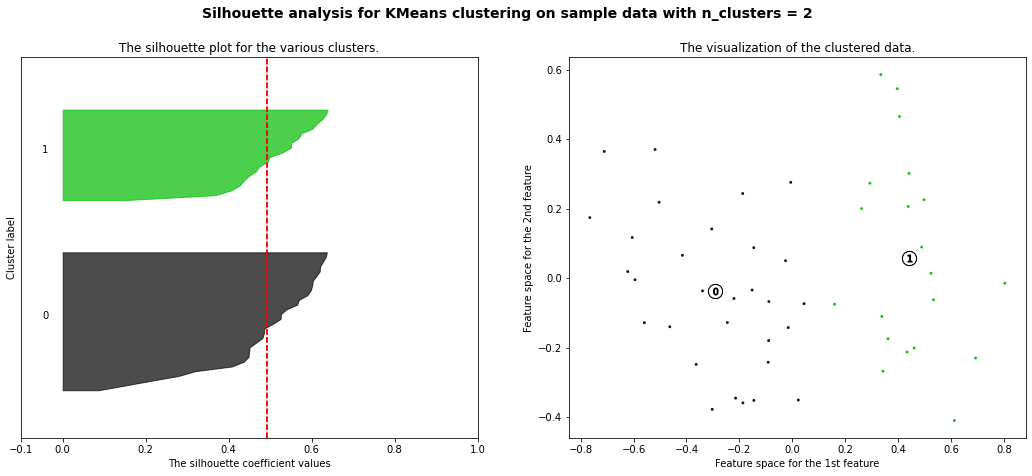

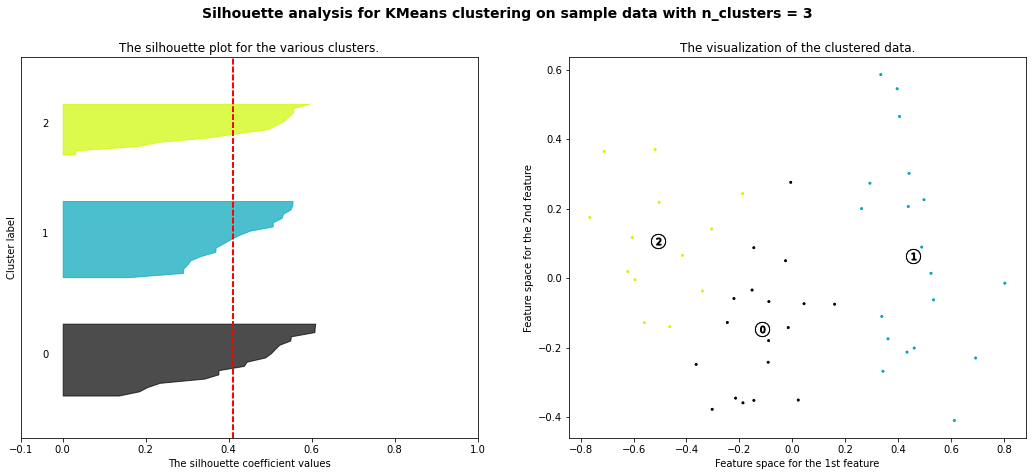

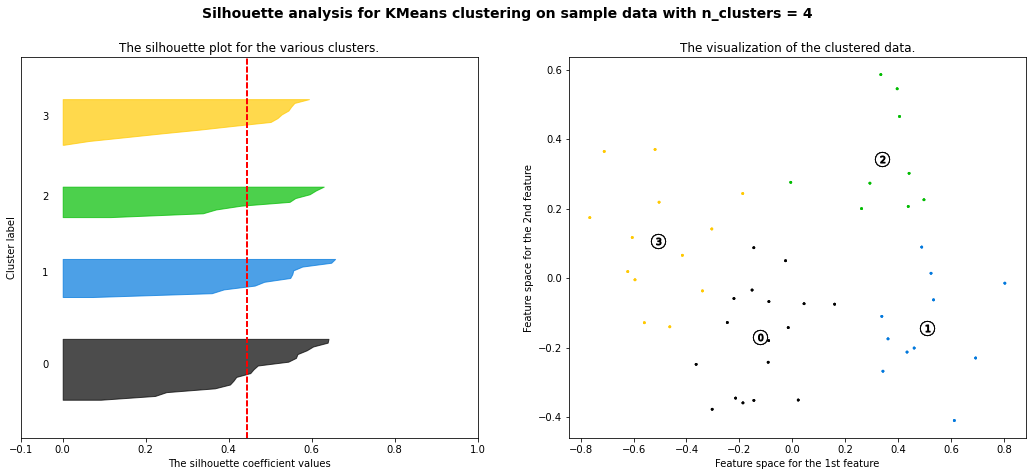

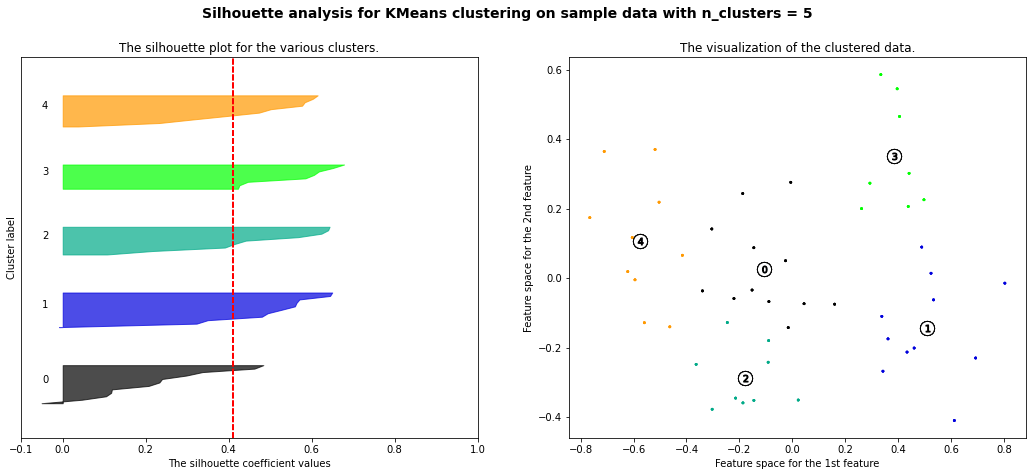

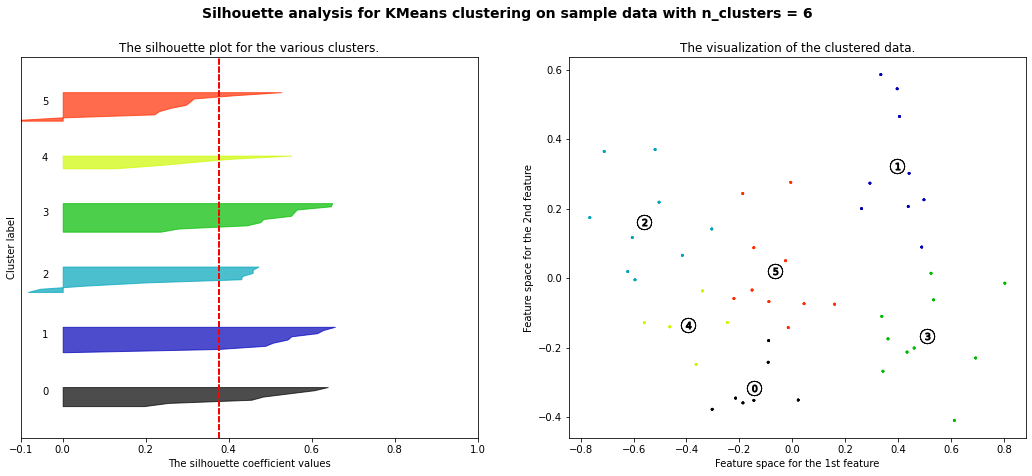

In [48]:
# you can find the original code here: 
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

n_clusters = [2, 3, 4 , 6]

silhouette_analisys(principal_components, n_clusters)


Data after clusterization

n_clusters equals 4 seems to be the best solution

<Figure size 432x288 with 0 Axes>

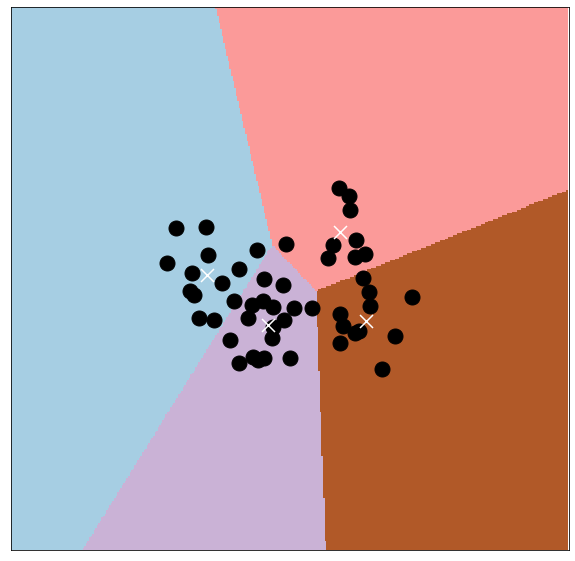

In [51]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(principal_components)
plot_clusters(principal_components, kmeans)

